## Import

In [2]:
import easyocr
import os
import torch
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
import random
import glob
from tqdm import tqdm
import numpy as np
import time
from mmocr_eval import eval_ocr_metric
import re
import cv2 as cv
from icecream import ic
import json

Font install

In [3]:
# https://www.kaggle.com/code/fulrose/how-to-apply-new-font-to-matplotlib-easily/notebook
def change_matplotlib_font(font_download_url):
    FONT_PATH = 'MY_FONT'

    # font_download_cmd = f"wget {font_download_url} -O {FONT_PATH}.zip"
    # unzip_cmd = f"unzip -o {FONT_PATH}.zip -d {FONT_PATH}"
    # os.system(font_download_cmd)
    # os.system(unzip_cmd)


    font_files = fm.findSystemFonts(fontpaths=FONT_PATH)
    for font_file in font_files:
        fm.fontManager.addfont(font_file)

    try:
        # print(font_files)
        font_name = fm.FontProperties(fname=font_files[0]).get_name()
    except:
        print('Font not found')
        font_name = 'Kanit'
    matplotlib.rc('font', family=font_name)
    print("font family: ", plt.rcParams['font.family'])

In [4]:
font_download_url = 'https://fonts.google.com/download?family=Kanit'
change_matplotlib_font(font_download_url)

font family:  ['Kanit']


## Install packges

In [5]:
# !pip install matplotlib
# !pip install rapidfuzz

In [6]:
torch.cuda.is_available()

True

## Testing

Load model by easyOCR API (https://www.jaided.ai/easyocr/documentation/)

In [4]:
start = time.time()
model = 'rosetta_hippo_300k_bw' #folder name of model
iteration = 'iter_78000' # model .pt file name

model_path = os.path.join('trainer', 'saved_models',model)
reader = easyocr.Reader(lang_list = ['en','th'],
                    model_storage_directory = model_path,
                    user_network_directory = os.path.join('my_model','user_network'),
                    recog_network  = iteration,
                    config_path = 'hippo_300k_bw', #configuration file name use to get character_list only  (so able to use for every model)
                    gpu = True)
# reader = easyocr.Reader(lang_list = ['en','th'],gpu = True )
end = time.time()
print(f'loading model time: {end - start}')

config: my_model/user_network/rosetta.yaml
--------------------
Transformation: None
FeatureExtraction: ResNet
SequenceModeling: None
Prediction: CTC
--------------------
model_path: trainer/saved_models/rosetta_hippo_300k_bw/iter_78000.pth
loading model time: 3.7146286964416504


In [ ]:
start = time.time()
model = 'rosetta_hippo_300k_v1' #folder name of model
iteration = 'iter_36000' # model .pt file name

# model_path = os.path.join('trainer', 'saved_models',model)
# reader2 = easyocr.Reader(lang_list = ['en','th'],
#                     model_storage_directory = model_path,
#                     user_network_directory = os.path.join('my_model','user_network'),
#                     recog_network  = iteration,
#                     config_path = 'hippo_300k_bw', #configuration file name use to get character_list only  (so able to use for every model)
#                     gpu = True)
# # reader = easyocr.Reader(lang_list = ['en','th'],gpu = True )
# end = time.time()
# print(f'loading model time: {end - start}')

### TRDG testset

visualize all trdg testset

In [ ]:
list_im = [789, 782, 575, 779, 589, 714, 999 ,683]
filepaths = glob.glob(os.path.join('trainer/all_data/testing/testing','*.jpg'))
# filepaths = glob.glob(os.path.join('trainer/all_data/training/training','*.jpg'))
filepaths = sorted(filepaths, key= lambda x: int(re.split(r'[/\\.]',x)[-2]))

font_name = 'Kanit'
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0
all_pred = []
columns = 4
rows = 4
fig = plt.figure(figsize=(15, 15))
ax = []
for i in tqdm(range(columns*rows)):
    # random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/testing')),1)[0]
    # random_file_path = os.path.join('trainer/all_data/testing/testing',random_file_name)
    #random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/testing')),1)[0]

    random_file_path = random.sample(filepaths,1)[0]
    # random_file_path = filepaths[1]
    # random_file_path = filepaths[list_im.pop(0)]
    img = plt.imread(random_file_path)
    result = reader.recognize(random_file_path)
    all_pred.append(result[0][1])
    ax.append(fig.add_subplot(rows, columns, i+1) )
    boxs = []
    txt = []
    for idx,i in enumerate(result):
        boxs.append(i[0])
        txt.append(i[1])
    plt.axis('off')
    if len(result) > 0:
        ax[-1].set_title(f'{idx+1} predict: {txt}' , fontsize=20)
        # for i in boxs:
        #     pts = np.array(i, np.int32)
        #     pts = pts.reshape((-1,1,2))
        #     cv.polylines(img,[pts],True,(0,0,0))

        
    else:
        ax[-1].set_title('No result', fontsize=20)
    plt.imshow(img)
fig.tight_layout() 
plt.show()
print(all_pred)

In [ ]:
# filepaths = glob.glob(os.path.join('trainer/all_data/testing/testing','*.jpg'))
# label_path = 'trainer/all_data/testing/testing/label.txt'
# with open(label_path, encoding='utf8') as file:
#     label = np.loadtxt(file,dtype=str)

In [ ]:
# columns = 5
# rows = 200
# fig, ax = plt.subplots(rows, columns, figsize=(20, 20))
# ax.set_facecolor("white")
# counter = 0
# for r in tqdm(range(rows)):
#     for c in range(columns):
#         file_name = re.split(r'[/\\]',filepaths[counter])[-1]
#         file_path = os.path.join('trainer/all_data/testing/testing',file_name)
#         img = plt.imread(file_path)
#         ax[r, c].axis('off')
#         result = reader.readtext(file_path) 
#         if len(result) > 0:
#             txt = ''
#             for i in result:
#                 txt += (' '+i[1])
#             ax[r, c].set_title(f'{file_name} predict: {txt}')
#         else:
#             ax[r, c].set_title('No result')
#         ax[r, c].imshow(img)
#         counter += 1
# plt.subplots_adjust(top = 20)

testing with trdg testset

In [ ]:
filepaths = glob.glob(os.path.join('trainer/all_data/testing/testing','*.jpg'))
# filepaths = glob.glob(os.path.join('trainer/all_data/training/training','*.jpg'))[:1000]
filepaths = sorted(filepaths, key= lambda x: int(re.split(r'[/\\.]',x)[-2]))
label_path = 'trainer/all_data/testing/testing/label.txt'
with open(label_path, encoding='utf8') as file:
    label = np.loadtxt(file,dtype=str)

start = time.time()
# filepaths = filepaths[:3]
pred = []
gt = [] # ground truth
name_img = []
for i in tqdm(range(len(filepaths))):
    label_img = label[i][1]
    name_img.append(label[i][0])
    result = reader.recognize(filepaths[i],detail=0)
    try:
        pred.append(result)
    except:
        pred.append('')
    gt.append(label_img)
end = time.time()
print(f'time: {end - start}')

In [ ]:
tmp = name_img.copy()
output, false_list = eval_ocr_metric(pred, gt, tmp)
# output, false_list = eval_ocr_metric(pred, gt, name_img)
for k,v in output.items():
    print(f'{k}: {v}')

samples testing with flase prediction from trdg

In [ ]:

# plt.rcParams['xtick.labelsize'] = 20.0
# plt.rcParams['ytick.labelsize'] = 20.0
# columns = 3
# rows = 5
# fig = plt.figure(figsize=(15, 15))
# ax = []
# all_pred = []
# for i in tqdm(range(columns*rows)):
#     # random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/testing')),1)[0]
#     # random_file_path = os.path.join('trainer/all_data/testing/testing',random_file_name)
#     #random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/testing')),1)[0]

#     random_file_name = random.sample(false_list,1)[0]
#     random_file_name = random_file_name[0]
#     random_file_path = os.path.join('trainer/all_data/testing/testing',random_file_name)

#     img = plt.imread(random_file_path)
#     result = reader.recognize(random_file_path)
#     ax.append(fig.add_subplot(rows, columns, i+1) )
#     # boxs = []
#     txt = []
#     for idx,i in enumerate(result):
#         # boxs.append(i[0])
#         txt.append(i[1])
#     all_pred.append(txt)
#     plt.axis('off')
#     if len(result) > 0:
#         ax[-1].set_title(f'file: {random_file_name} {idx}: {txt} ', fontsize=20) 
#         # for i in boxs:
#         #         pts = np.array(i, np.int32)
#         #         pts = pts.reshape((-1,1,2))
#         #         cv.polylines(img,[pts],True,(0,0,0))
#     else:
#         ax[-1].set_title(f'file: {random_file_name} No result', fontsize=20)
#     plt.imshow(img)
# fig.tight_layout() 
# plt.show()
# print(all_pred)

### LMWN testset

samepls with LMWN

In [ ]:

# plt.rcParams['xtick.labelsize'] = 20.0
# plt.rcParams['ytick.labelsize'] = 20.0
# columns = 2
# rows = 10
# fig = plt.figure(figsize=(20, 20))
# ax = []
# for i in range(columns*rows):
#     random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/LMWN')),1)[0]
#     # random_file_path = os.path.join('trainer/all_data/testing/testing',random_file_name)
#     #random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/testing')),1)[0]
#     # random_file_name = os.listdir(os.path.join('trainer/all_data/testing/LMWN'))[2]
#     random_file_path = os.path.join('trainer/all_data/testing/LMWN',random_file_name)
#     img = plt.imread(random_file_path)
#     result = reader.recognize(random_file_path) 
#     ax.append(fig.add_subplot(rows, columns, i+1))
#     plt.axis('off')
#     if len(result) > 0:
#         ax[-1].set_title(f'predict: "{result[0][1]}" ', fontsize=10)
#         # pts = np.array(result[0][0], np.int32)
#         # pts = pts.reshape((-1,1,2))
#         # cv.polylines(img,[pts],True,(255,0,0))
#     else:
#         ax[-1].set_title('No result',fontsize=10)
#     plt.imshow(img)
# fig.tight_layout() 
# plt.show()

### Google OCR testset

samples with google ocr 

In [ ]:
# plt.rcParams['xtick.labelsize'] = 20.0
# plt.rcParams['ytick.labelsize'] = 20.0
# columns = 2
# rows = 10
# fig = plt.figure(figsize=(15, 15))
# ax = []
# all_pred = []
# for i in tqdm(range(columns*rows)):
#     random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/google_ocr_test_images')),1)[0]
#     random_file_path = os.path.join('trainer/all_data/testing/google_ocr_test_images',random_file_name)

#     img = plt.imread(random_file_path)
#     result = reader.recognize(random_file_path)
#     ax.append(fig.add_subplot(rows, columns, i+1) )
#     # boxs = []
#     txt = []
#     for idx,i in enumerate(result):
#         # boxs.append(i[0])
#         txt.append(i[1])
#     all_pred.append(txt)
#     plt.axis('off')
#     if len(result) > 0:
#         ax[-1].set_title(f'file: {random_file_name} {idx}: {txt} ', fontsize=15) 
#         # for i in boxs:
#         #         pts = np.array(i, np.int32)
#         #         pts = pts.reshape((-1,1,2))
#         #         cv.polylines(img,[pts],True,(0,0,0))
#     else:
#         ax[-1].set_title(f'file: {random_file_name} No result', fontsize=15)
#     plt.imshow(img)
# fig.tight_layout() 
# plt.show()
# print(all_pred)

testing with google ocr testset

In [ ]:
filepaths = glob.glob(os.path.join('trainer/all_data/testing/google_ocr_test_images','*.jpg'))
# filepaths = glob.glob(os.path.join('trainer/all_data/training/training','*.jpg'))[:1000]
filepaths = sorted(filepaths, key= lambda x: int(re.split(r'[/\\.]',x)[-2]))
label_path = 'trainer/all_data/testing/google_ocr_test_images/image.txt'
label= []
with open(label_path, encoding='utf8') as file:
    lines = file.readlines()
    for line in lines:
        label.append(eval(line))
start = time.time()
# filepaths = filepaths[:3]
pred = []
gt = [] # ground truth
name_img = []
print(len(filepaths), len(label))
for i in tqdm(range(len(filepaths))):
    label_img = label[i]['text']
    name_img.append(label[i]['filename'])
    result = reader.recognize(filepaths[i],detail=0)
    try:
        pred.append(result)
    except:
        pred.append('')
    gt.append(label_img)
end = time.time()
print(f'time: {end - start}')

In [ ]:
tmp = name_img.copy()
output, false_list = eval_ocr_metric(pred, gt, tmp)
# output, false_list = eval_ocr_metric(pred, gt, name_img)
for k,v in output.items():
    print(f'{k}: {v}')

testing with black-white

In [ ]:
filepaths = glob.glob(os.path.join('trainer/all_data/testing/test_bw','*.jpg'))
filepaths = sorted(filepaths, key= lambda x: int(re.split(r'[/\\.]',x)[-2]))
label_path = 'trainer/all_data/testing/test_bw/label.txt'
label= []
with open(label_path, encoding='utf8') as file:
    lines = file.readlines()
    for line in lines:
        label.append(eval(line))
start = time.time()
# filepaths = filepaths[:3]
pred = []
gt = [] # ground truth
name_img = []
print(len(filepaths), len(label))
for i in tqdm(range(len(filepaths))):
    label_img = label[i]['text']
    name_img.append(label[i]['filename'])
    result = reader.recognize(filepaths[i],detail=0)
    try:
        pred.append(result)
    except:
        pred.append('')
    gt.append(label_img)
end = time.time()
print(f'time: {end - start}')

In [ ]:
tmp = name_img.copy()
output, false_list = eval_ocr_metric(pred, gt, tmp)
# output, false_list = eval_ocr_metric(pred, gt, name_img)
for k,v in output.items():
    print(f'{k}: {v}')

samples testing with flase prediction from google oce

In [ ]:

# plt.rcParams['xtick.labelsize'] = 20.0
# plt.rcParams['ytick.labelsize'] = 20.0
# columns = 1
# rows = 10
# fig = plt.figure(figsize=(15, 15))
# ax = []
# all_pred = []
# for i in tqdm(range(columns*rows)):
#     # random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/testing')),1)[0]
#     # random_file_path = os.path.join('trainer/all_data/testing/testing',random_file_name)
#     #random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/testing')),1)[0]

#     random_file_name = random.sample(false_list,1)[0]
#     random_file_name = random_file_name[0]
#     random_file_path = os.path.join('trainer/all_data/testing/google_ocr_test_images',random_file_name)

#     img = plt.imread(random_file_path)
#     result = reader.recognize(random_file_path)
#     ax.append(fig.add_subplot(rows, columns, i+1) )
#     # boxs = []
#     txt = []
#     for idx,i in enumerate(result):
#         # boxs.append(i[0])
#         txt.append(i[1])
#     all_pred.append(txt)
#     plt.axis('off')
#     if len(result) > 0:
#         ax[-1].set_title(f'file: {random_file_name} {idx}: {txt} ', fontsize=20) 
#         # for i in boxs:
#         #         pts = np.array(i, np.int32)
#         #         pts = pts.reshape((-1,1,2))
#         #         cv.polylines(img,[pts],True,(0,0,0))
#     else:
#         ax[-1].set_title(f'file: {random_file_name} No result', fontsize=20)
#     plt.imshow(img)
# fig.tight_layout() 
# plt.show()
# print(all_pred)

### AIA testset

samepls with aia (random image + random text box)

In [ ]:
# plt.rcParams['xtick.labelsize'] = 20.0
# plt.rcParams['ytick.labelsize'] = 20.0
# columns = 1
# rows = 1
# fig = plt.figure(figsize=(5, 5))
# ax = []
# all_pred = []
# for i in tqdm(range(columns*rows)):
#     filepaths_list = glob.glob(os.path.join('trainer/all_data/testing/data_aia_mmocr','*.jpg'))
#     random_filepath = random.sample(filepaths_list,1)[0]

#     img = plt.imread(random_filepath)
#     box_pos_json = random_filepath+'.json'
#     with open(box_pos_json, 'r') as f:
#         box_pos = json.load(f)
#     box_pos_random = random.sample(box_pos['result']['horizontal_box'],1)[0]
#     crop = img[box_pos_random[2]:box_pos_random[3],box_pos_random[0]:box_pos_random[1]]

#     result = reader.recognize(crop)
#     ax.append(fig.add_subplot(rows, columns, i+1) )
#     # boxs = []
#     txt = []
#     for idx,i in enumerate(result):
#         # boxs.append(i[0])
#         txt.append(i[1])
#     all_pred.append(txt)
#     plt.axis('off')
#     if len(result) > 0:
#         ax[-1].set_title(f'file: {idx}: {txt} ', fontsize=20) 
#     else:
#         ax[-1].set_title(f'file: No result', fontsize=20)
#     plt.imshow(crop)
# fig.tight_layout() 
# plt.show()
# print(all_pred)


2 model comparision

In [ ]:
# plt.rcParams['xtick.labelsize'] = 20.0
# plt.rcParams['ytick.labelsize'] = 20.0
# columns = 1
# rows = 1
# fig = plt.figure(figsize=(5, 5))
# ax = []
# all_pred = []
# for i in tqdm(range(columns*rows)):
#     filepaths_list = glob.glob(os.path.join('trainer/all_data/testing/data_aia_mmocr','*.jpg'))
#     random_filepath = random.sample(filepaths_list,1)[0]

#     img = plt.imread(random_filepath)
#     box_pos_json = random_filepath+'.json'
#     with open(box_pos_json, 'r') as f:
#         box_pos = json.load(f)
#     box_pos_random = random.sample(box_pos['result']['horizontal_box'],1)[0]
#     crop = img[box_pos_random[2]:box_pos_random[3],box_pos_random[0]:box_pos_random[1]]

#     result = reader.recognize(crop)
#     result2 = reader2.recognize(crop)
#     ax.append(fig.add_subplot(rows, columns, i+1) )
#     # boxs = []
#     txt = []
#     txt2 = []
#     for idx,i in enumerate(zip(result,result2)):
#         txt.append(i[0][1])
#         txt2.append(i[1][1])
#     all_pred.append(txt)
#     plt.axis('off')

#     if len(result) > 0:
#         # ax[-1].set_title(f'file: {idx}: {txt} {txt2}', fontsize=20) 
#         filename = re.split(r'[/\\.]',random_filepath)[-2]
#         ax[-1].set_title(f'file: {filename}', fontsize=20)
#     else:
#         ax[-1].set_title(f'file: No result', fontsize=20)
#     plt.imshow(crop)
# plt.show()
# print(f'   rosetta {txt}')
# print(f'   crnn    {txt2}')

samepls with aia (random image + all text box)

In [ ]:
# filepaths_list = glob.glob(os.path.join('trainer/all_data/testing/data_aia_mmocr','*.jpg'))
# random_filepath = random.sample(filepaths_list,1)[0]
# img = plt.imread(random_filepath)
# box_pos_json = random_filepath+'.json'
# with open(box_pos_json, 'r') as f:
#     box_pos = json.load(f)
# box_count = len(box_pos['result']['horizontal_box'])
# col = 2
# row = int(box_count/col)+1
# fig = plt.figure(figsize=(15, 15))
# ax = []
# all_pred = []
# for i_box, box in enumerate(tqdm(box_pos['result']['horizontal_box'])):
#     crop = img[box[2]:box[3],box[0]:box[1]]
#     result = reader.recognize(crop)
#     ax.append(fig.add_subplot(row, col, i_box+1) )
#     txt = []
#     for idx,i in enumerate(result):
#         txt.append(i[1])
#     all_pred.append(txt)
#     plt.axis('off')
#     if len(result) > 0:
#         ax[-1].set_title(f'file: {idx}: {txt} ', fontsize=15) 
#     else:
#         ax[-1].set_title(f'file: No result', fontsize=15)
#     plt.imshow(crop)
# fig.tight_layout()
# fig = plt.figure(figsize=(10, 10))
# plt.axis('off')
# plt.imshow(img)
# plt.show()
# print(all_pred)
# print(random_filepath)

### comparison

In [ ]:
def load_model(model, iteration):
    model_path = os.path.join('trainer', 'saved_models',model)
    reader = easyocr.Reader(lang_list = ['en','th'],
                        model_storage_directory = model_path,
                        user_network_directory = os.path.join('my_model','user_network'),
                        recog_network  = iteration,
                        config_path = 'hippo_300k_bw', #configuration file name use to get character_list only  (so able to use for every model)
                        gpu = True)
    return reader

In [ ]:
model_list = ['crnn_hippo_300k_v1-iter_34000', 'rosetta_hippo_300k_v1-iter_36000', 'crnn_hippo_300k_bw-iter_88000', 'rosetta_hippo_300k_bw-iter_78000']
reader_list = []
reader_easyocr = easyocr.Reader(lang_list = ['en','th'],gpu = True )
for model in model_list:
    model_name = model.split('-')[0]
    iteration = model.split('-')[1]
    reader_list.append((model_name, load_model(model_name, iteration)))

aia

In [ ]:
from tabulate import tabulate
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0
columns = 1
rows = 1
fig = plt.figure(figsize=(5, 5))
ax = []
all_pred = []
for i in tqdm(range(columns*rows)):
    result = []
    filepaths_list = glob.glob(os.path.join('trainer/all_data/testing/data_aia_mmocr','*.jpg'))
    random_filepath = random.sample(filepaths_list,1)[0]

    img = plt.imread(random_filepath)
    box_pos_json = random_filepath+'.json'
    with open(box_pos_json, 'r') as f:
        box_pos = json.load(f)
    box_pos_random = random.sample(box_pos['result']['horizontal_box'],1)[0]
    crop = img[box_pos_random[2]:box_pos_random[3],box_pos_random[0]:box_pos_random[1]]

    for reader in reader_list:
        result.append((reader[0], reader[1].recognize(crop)))

    result.append(('EasyOCR', reader_easyocr.recognize(crop)))
    ax.append(fig.add_subplot(rows, columns, i+1) )
    
    plt.axis('off')
    filename = re.split(r'[/\\.]',random_filepath)[-2]
    ax[-1].set_title(f'file: {filename}', fontsize=20)
    plt.imshow(crop)
    
plt.show()
table = []
for idx,i in enumerate(result):
        table.append([i[0],i[1][0][1]])
tabulate(table, headers=['model', 'predict'], tablefmt='html')

LMWN

In [ ]:
from tabulate import tabulate
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0
columns = 1
rows = 1
fig = plt.figure(figsize=(5, 5))
ax = []
all_pred = []
for i in tqdm(range(columns*rows)):
    result = []
    filepaths_list = glob.glob(os.path.join('trainer/all_data/testing/LMWN','*.jpg'))
    random_filepath = random.sample(filepaths_list,1)[0]

    img = plt.imread(random_filepath)

    for reader in reader_list:
        result.append((reader[0], reader[1].recognize(img)))
    result.append(('EasyOCR', reader_easyocr.recognize(img)))
    ax.append(fig.add_subplot(rows, columns, i+1) )
    
    plt.axis('off')
    filename = re.split(r'[/\\.]',random_filepath)[-2]
    ax[-1].set_title(f'file: {filename}', fontsize=20)
    plt.imshow(img)
    
plt.show()
table = []
for idx,i in enumerate(result):
        table.append([i[0],i[1][0][1]])
tabulate(table, headers=['model', 'predict'], tablefmt='html')

### testing all iterations model

In [7]:
def load_model(model_path, iteration):
    reader = easyocr.Reader(lang_list = ['en','th'],
                    model_storage_directory = model_path,
                    user_network_directory = os.path.join('my_model','user_network'),
                    recog_network  = iteration,
                    config_path = 'hippo_300k_synthtiger', #configuration file name use to get character_list only  (so able to use for every model)
                    gpu = True)
    return reader

In [8]:
def test_all_testset(reader, test_set_path, test_set_label):
    filepaths = test_set_path
    filepaths = sorted(filepaths, key= lambda x: int(re.split(r'[/\\.]',x)[-2]))
    label_path = test_set_label
    try:
        with open(label_path, encoding='utf8') as file:
                label = np.loadtxt(file,dtype=str)
    except:
        with open(label_path, encoding='utf8') as file:
            label = []
            lines = file.readlines()
            for line in lines:
                label.append(eval(line))
            

    start = time.time()
    # filepaths = filepaths[:3]
    pred = []
    gt = [] # ground truth
    name_img = []
    for i in range(len(filepaths)):
        try:
            label_img = label[i][1]
            name_img.append(label[i][0])
        except:
            label_img = label[i]['text']
            name_img.append(label[i]['filename'])
        
        result = reader.recognize(filepaths[i],detail=0)
        try:
            pred.append(result)
        except:
            pred.append('')
        gt.append(label_img)
    end = time.time()
    print(f'time: {end - start}')
    return pred, gt, name_img

testing with trdg

In [8]:
import csv
result_loop = []
with open('loop_result_300k_synthtiger.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        result_loop.append(row)

In [9]:
from IPython.display import clear_output
model = 'rosetta_300k_synthtiger' #folder name of model
model_path = os.path.join('trainer', 'saved_models',model)
test_set = 'testing'
test_set_path = glob.glob(os.path.join('trainer/all_data/testing/',test_set,'*.jpg'))
test_set_label = os.path.join('trainer/all_data/testing/',test_set,'label.txt')
files_list = os.listdir(model_path)
result = {}
testing_list = []
print(f'!!!!!!! model name : {model} !!!!!!!')
for i_file,r in enumerate(result_loop):
    if r[0] == model and r[1] == 'trdg': 
        testing_list = r.copy()
        break

max_ = 0
try:
    if len(testing_list[2]) > 0:
        for i in eval(testing_list[2]):
            cur = int(i.split('_')[1])
            if cur > max_:
                max_ = cur
except:
    pass

files_list = [i for i in files_list if i.startswith('iter') and int(i.split('.')[0].split('_')[1]) > max_]
print(len(files_list))
for file in tqdm(files_list):
    iteration = file.split('.pth')[0]
    reader = load_model(model_path, iteration)
    pred, gt, name_img = test_all_testset(reader, test_set_path, test_set_label)
    tmp = name_img.copy()
    output, false_list = eval_ocr_metric(pred, gt, tmp)
    # output, false_list = eval_ocr_metric(pred, gt, name_img)
    result[iteration] = output
    clear_output(wait=True)
    # pbar.update(1)
        
result

100%|██████████| 40/40 [12:51<00:00, 19.28s/it]


{'iter_18000': {'char_recall': 0.8237,
  'char_precision': 0.939,
  'word_acc': 0.622,
  'word_acc_ignore_case': 0.645,
  'word_acc_ignore_case_symbol': 0.807,
  '1-N.E.D': 0.8893},
 'iter_44000': {'char_recall': 0.8455,
  'char_precision': 0.9533,
  'word_acc': 0.718,
  'word_acc_ignore_case': 0.729,
  'word_acc_ignore_case_symbol': 0.855,
  '1-N.E.D': 0.9099},
 'iter_64000': {'char_recall': 0.8502,
  'char_precision': 0.9738,
  'word_acc': 0.77,
  'word_acc_ignore_case': 0.783,
  'word_acc_ignore_case_symbol': 0.885,
  '1-N.E.D': 0.9242},
 'iter_50000': {'char_recall': 0.8487,
  'char_precision': 0.9627,
  'word_acc': 0.733,
  'word_acc_ignore_case': 0.744,
  'word_acc_ignore_case_symbol': 0.859,
  '1-N.E.D': 0.9212},
 'iter_80000': {'char_recall': 0.8766,
  'char_precision': 0.9555,
  'word_acc': 0.782,
  'word_acc_ignore_case': 0.792,
  'word_acc_ignore_case_symbol': 0.886,
  '1-N.E.D': 0.9267},
 'iter_38000': {'char_recall': 0.8417,
  'char_precision': 0.9515,
  'word_acc': 0.691,

In [19]:
for k,v in result.items():
    print(f'{k}: {v["word_acc"]}')

iter_18000: 0.622
iter_44000: 0.718
iter_64000: 0.77
iter_50000: 0.733
iter_80000: 0.782
iter_38000: 0.691
iter_76000: 0.782
iter_60000: 0.783
iter_30000: 0.631
iter_48000: 0.725
iter_20000: 0.624
iter_66000: 0.775
iter_42000: 0.696
iter_26000: 0.645
iter_10000: 0.544
iter_34000: 0.693
iter_28000: 0.661
iter_32000: 0.686
iter_46000: 0.704
iter_74000: 0.77
iter_54000: 0.758
iter_62000: 0.763
iter_16000: 0.595
iter_4000: 0.238
iter_22000: 0.622
iter_72000: 0.781
iter_36000: 0.706
iter_8000: 0.445
iter_40000: 0.725
iter_14000: 0.577
iter_12000: 0.555
iter_52000: 0.736
iter_56000: 0.767
iter_24000: 0.625
iter_78000: 0.786
iter_6000: 0.409
iter_58000: 0.764
iter_70000: 0.784
iter_2000: 0.011
iter_68000: 0.778


testing with google ocr

In [32]:
import csv
result_loop = []
with open('loop_result_300k_synthtiger.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        result_loop.append(row)

In [34]:
from IPython.display import clear_output
model = 'rosetta_300k_synthtiger' #folder name of model
model_path = os.path.join('trainer', 'saved_models',model)
test_set = 'google_ocr_test_images'
test_set_path = glob.glob(os.path.join('trainer/all_data/testing/',test_set,'*.jpg'))
if test_set == 'google_ocr_test_images':
    test_set_label = os.path.join('trainer/all_data/testing/',test_set,'image.txt')
else :
    test_set_label = os.path.join('trainer/all_data/testing/',test_set,'label.txt')
files_list = os.listdir(model_path)

result = {}
testing_list = []
print(f'!!!!!!! model name : {model} !!!!!!!')
for i_file,r in enumerate(result_loop):
    if r[0] == model and r[1] == 'google': 
        testing_list = r.copy()
        break
max_ = 0
if len(testing_list[2]) > 0:
    for i in eval(testing_list[2]):
        cur = int(i.split('_')[1])
        if cur > max_:
            max_ = cur
files_list = [i for i in files_list if i.startswith('iter') and int(i.split('.')[0].split('_')[1]) > max_]
print(len(files_list))
for file in tqdm(files_list):
    iteration = file.split('.pth')[0]
    reader = load_model(model_path, iteration)
    pred, gt, name_img = test_all_testset(reader, test_set_path, test_set_label)
    tmp = name_img.copy()
    output, false_list = eval_ocr_metric(pred, gt, tmp)
    # output, false_list = eval_ocr_metric(pred, gt, name_img)
    result[iteration] = output
    clear_output(wait=True)
    # pbar.update(1)
        
result

100%|██████████| 40/40 [27:46<00:00, 41.66s/it]


{'iter_18000': {'char_recall': 0.9497,
  'char_precision': 0.9635,
  'word_acc': 0.5758,
  'word_acc_ignore_case': 0.5817,
  'word_acc_ignore_case_symbol': 0.8094,
  '1-N.E.D': 0.9459},
 'iter_44000': {'char_recall': 0.9625,
  'char_precision': 0.9683,
  'word_acc': 0.6279,
  'word_acc_ignore_case': 0.6302,
  'word_acc_ignore_case_symbol': 0.8428,
  '1-N.E.D': 0.9576},
 'iter_64000': {'char_recall': 0.963,
  'char_precision': 0.9725,
  'word_acc': 0.6731,
  'word_acc_ignore_case': 0.6761,
  'word_acc_ignore_case_symbol': 0.8562,
  '1-N.E.D': 0.9649},
 'iter_50000': {'char_recall': 0.9632,
  'char_precision': 0.9714,
  'word_acc': 0.6544,
  'word_acc_ignore_case': 0.6575,
  'word_acc_ignore_case_symbol': 0.859,
  '1-N.E.D': 0.9676},
 'iter_80000': {'char_recall': 0.9689,
  'char_precision': 0.9681,
  'word_acc': 0.6812,
  'word_acc_ignore_case': 0.6837,
  'word_acc_ignore_case_symbol': 0.8587,
  '1-N.E.D': 0.961},
 'iter_38000': {'char_recall': 0.9616,
  'char_precision': 0.9703,
  'wor

In [ ]:
for k,v in result.items():
    print(f'{k}: {v["word_acc"]}')

In [35]:
i_file

3

write log

In [36]:
import csv
result_loop = []
with open('loop_result_300k_synthtiger.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        result_loop.append(row)

In [37]:
if len(result_loop[i_file][2]) > 0:
    old_result = eval(result_loop[i_file][2])
    new_result = old_result.copy()
    for k,v in result.items():
        new_result[k] = v
else:
    new_result = result.copy()
len(new_result)

40

In [38]:
# print(result_loop[i_file])
result_loop[i_file][2] = str(new_result)
with open('loop_result_300k_synthtiger.csv', 'w') as file:
    for i in result_loop:
        file.write(f'{i[0]},{i[1]},"{i[2]}"'+'\n')


In [ ]:
for k,v in result.items():
    print(f'{k}: {v["word_acc"]}')

analysis word accuracy vs iterations

In [24]:
# result_loop = []
# with open('loop_result.csv', 'a') as file:
#     file.writeline('test1')

In [25]:
import csv
result_loop = []
with open('loop_result_300k_synthtiger.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        result_loop.append(row)

In [26]:
# row = 0

# txt = eval(result_loop[row][2])
# model_name = result_loop[row][0]
# testset_name = result_loop[row][1]
# print(f'{model_name} {testset_name}')
# print(txt['iter_2000'])

rosetta_hippo_300k_bw trdg 78000 0.786


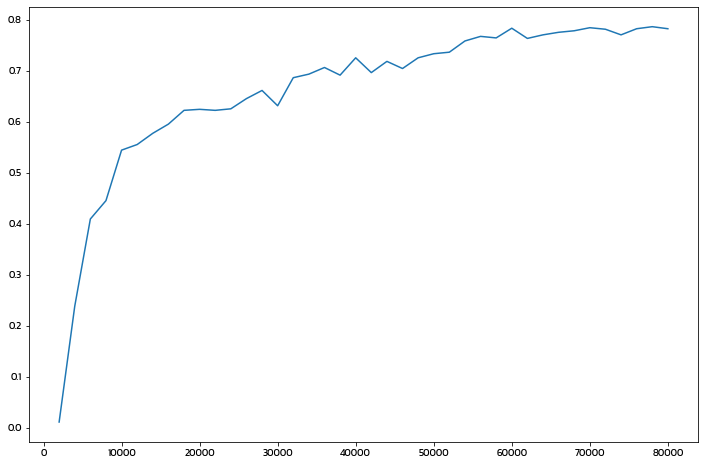

In [28]:
import matplotlib.pyplot as plt
columns = 2
rows = 2
fig = plt.figure(figsize=(12, 8))
for i in range(len(result_loop)):
    x = []
    y = []
    try:
        txt = eval(result_loop[i][2])
        model_name = result_loop[i][0]
        testset_name = result_loop[i][1]
        key_sorted = sorted(txt, key= lambda x: int(x.split('_')[1]))
        for k in key_sorted:
            x.append(int(k.split('_')[1]))
            y.append(txt[k]['word_acc'])
        if len(y) > 0:
            print(f'{model_name} {testset_name} {x[y.index(max(y))]} {max(y)}')
            plt.plot(x,y)
        if i % 2 == 1:
            plt.title(f'model name: {model_name}\n Word Accuracy vs Iteration')
            plt.legend([result_loop[i-1][1], result_loop[i][1]], loc ="lower right")
            plt.xlabel('Iteration')
            plt.ylabel('Word Accuracy')
            plt.show()
            fig = plt.figure(figsize=(12, 8))
    except:
        pass